In [1]:
!pip install lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install -U scikit-learn lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sklearn
print(sklearn.__version__)


1.7.2


In [6]:
from pathlib import Path
import pandas as pd

# 후보 경로들을 순서대로 점검
candidates = [
    Path.cwd() / "app" / "data_pipeline",
    Path.cwd().parents[0] / "data_pipeline",
    Path.cwd().parents[0] / "app" / "data_pipeline",
    Path.cwd().parents[1] / "app" / "data_pipeline",
    Path("python-server/app/data_pipeline").resolve(),
]

BASE = next((p for p in candidates if p.exists()), None)
print("BASE:", BASE)

if BASE is None:
    raise FileNotFoundError("data_pipeline 폴더를 찾지 못했습니다. 노트북 위치를 확인하세요.")

TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"

print("Exists? TR:", TR.exists(), "TE:", TE.exists())
tr = pd.read_csv(TR, parse_dates=["target_date"])
te = pd.read_csv(TE, parse_dates=["target_date"])

print("Train/Test shapes:", tr.shape, te.shape)


BASE: C:\Users\chosw\ORDER101_DEMAND_FORECAST\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline
Exists? TR: True TE: True
Train/Test shapes: (266500, 42) (33800, 42)


In [16]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

target = "y"
ignore = ["warehouse_id","store_id","sku_id","region","target_date","split",target]
leaky = {"actual_order_qty", "share_norm", "promo_flag"}  # 누출 방지

# --- (1) promo_flag_prev 안전 생성: 없을 때만 생성 ---
for df_ in (tr, te):
    if "promo_flag" in df_.columns and "promo_flag_prev" not in df_.columns:
        df_["promo_flag_prev"] = (
            df_.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"]
              .shift(1).fillna(0)
        )

# --- (2) 피처 선택 + 중복 제거 ---
numeric_cols = tr.select_dtypes(include=["number","bool"]).columns.tolist()
features = [c for c in numeric_cols if c not in ignore and c not in leaky]
if "promo_flag_prev" in tr.columns:  # lag된 프로모만 사용
    features.append("promo_flag_prev")
# 중복 제거
features = list(dict.fromkeys(features))

print(f"사용 피처 수: {len(features)}개")
print(features)

# NaN 처리
for c in features:
    if tr[c].dtype.kind in "fi":
        tr[c] = tr[c].fillna(0.0); te[c] = te[c].fillna(0.0)
    else:
        tr[c] = tr[c].fillna(0);   te[c] = te[c].fillna(0)

# 학습
model = LGBMRegressor(
    n_estimators=1200, learning_rate=0.01,
    subsample=0.9, colsample_bytree=0.8,
    num_leaves=31, random_state=42
)
model.fit(tr[features], tr[target])

# 예측/평가
te_pred = np.clip(model.predict(te[features]), 0, None)
mae  = mean_absolute_error(te[target], te_pred)
mape = (np.abs(te[target] - te_pred) / np.maximum(te[target], 1)).mean() * 100
print(f"MAE={mae:.4f}, MAPE={mape:.2f}%")


사용 피처 수: 33개
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4', 'promo_flag_prev']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3385
[LightGBM] [Info] Number of data points in the train set: 266500, number of used features: 33
[LightGBM] [Info] Start training from score 57.265084
MAE=7.7195, MAPE=8.94%


In [17]:
import numpy as np
import pandas as pd

target = "y"

# 아직 예측 안했다면 생성
if "y_pred" not in te.columns:
    te["y_pred"] = np.clip(model.predict(te[features]), 0, None)

# 기본 정렬
te = te.sort_values(["warehouse_id","store_id","sku_id","target_date"]).reset_index(drop=True)


In [18]:
# SKU 단위 MAE / MAPE 요약
def mape(a, p):
    denom = np.maximum(a, 1)  # 0-division 방지
    return (np.abs(a - p) / denom).mean() * 100

sku_eval = (te
    .groupby("sku_id")
    .apply(lambda g: pd.Series({
        "n": len(g),
        "qty_sum": g[target].sum(),
        "mae": np.abs(g[target]-g["y_pred"]).mean(),
        "mape": mape(g[target].values, g["y_pred"].values)
    }))
    .sort_values(["qty_sum","mape"], ascending=[False, True])
)
sku_eval.head(10)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_69932\3793928618.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,n,qty_sum,mae,mape
sku_id,,,,
MIX-BRV-STAND-5L-2024,520.0,345265.0,32.461777,5.218494
WAT-SAM-GAL-45-2024,520.0,172598.0,18.106838,5.788835
WAT-APL-AW-41-2024,520.0,172572.0,18.236669,5.858656
TOA-BRN-2S-2024,520.0,142506.0,14.670153,5.728531
TOA-PHI-2S-2024,520.0,142322.0,14.631409,5.693491
MW-SAM-30L-2024,520.0,126219.0,12.622483,5.558911
DW-SAM-12P-2024,520.0,120325.0,12.118602,5.650969
DES-HP-STD-2024,520.0,120241.0,11.374271,5.279370
DES-SAM-STD-2024,520.0,120048.0,11.637721,5.420792


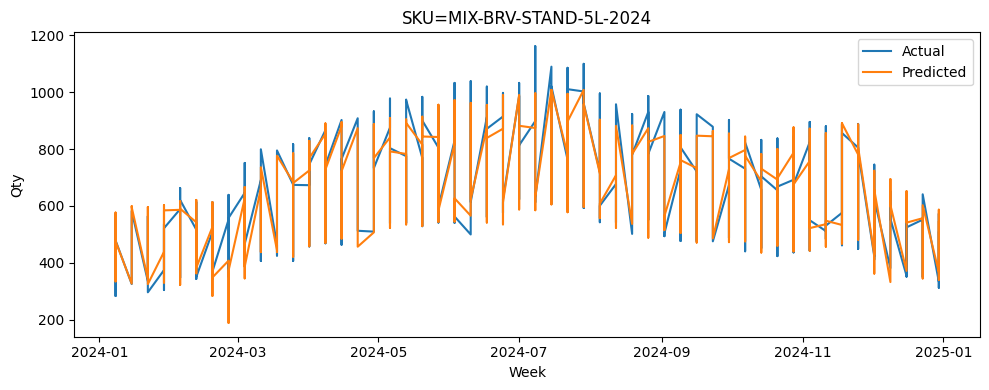

In [19]:
import matplotlib.pyplot as plt

def plot_sku(sku_id, store_id=None, wh_id=None):
    g = te[te["sku_id"]==sku_id].copy()
    if store_id is not None:
        g = g[g["store_id"]==store_id]
    if wh_id is not None:
        g = g[g["warehouse_id"]==wh_id]
    g = g.sort_values("target_date")
    if g.empty:
        print("조건에 맞는 데이터가 없습니다."); return

    plt.figure(figsize=(10,4))
    plt.plot(g["target_date"], g[target], label="Actual")
    plt.plot(g["target_date"], g["y_pred"], label="Predicted")
    ttl = f"SKU={sku_id}"
    if store_id is not None: ttl += f" | store={store_id}"
    if wh_id is not None:    ttl += f" | wh={wh_id}"
    plt.title(ttl)
    plt.xlabel("Week")
    plt.ylabel("Qty")
    plt.legend()
    plt.tight_layout()     
    plt.show()   
 
# 사용 예시: 상위 판매 SKU 하나 그려보기
top_sku = sku_eval.index[0]
plot_sku(top_sku)
  

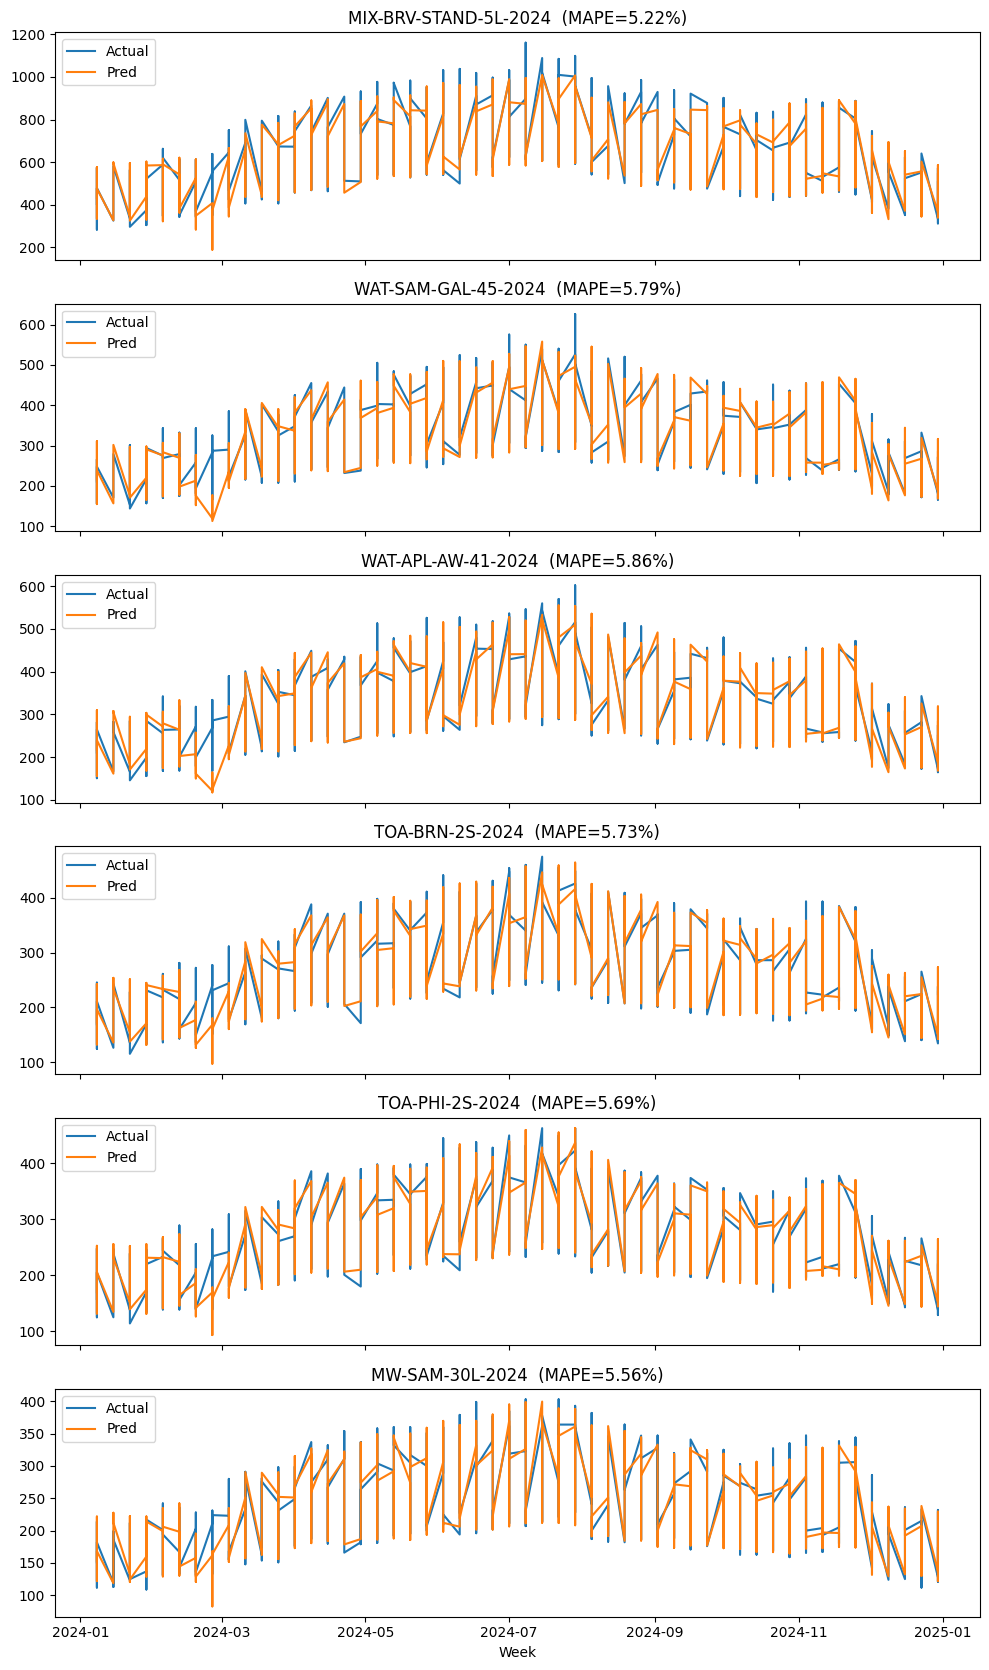

In [20]:
top6 = sku_eval.head(6).index.tolist()

fig, axes = plt.subplots(len(top6), 1, figsize=(10, 2.8*len(top6)), sharex=True)
if len(top6)==1:
    axes = [axes]

for ax, sku_id in zip(axes, top6):
    g = te[te["sku_id"]==sku_id].sort_values("target_date")
    ax.plot(g["target_date"], g[target], label="Actual")
    ax.plot(g["target_date"], g["y_pred"], label="Pred")
    ax.set_title(f"{sku_id}  (MAPE={mape(g[target].values,g['y_pred'].values):.2f}%)")
    ax.legend(loc="upper left")

plt.xlabel("Week")
plt.tight_layout()
plt.show()


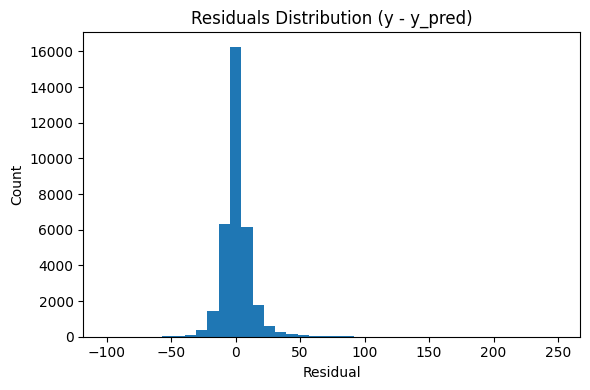

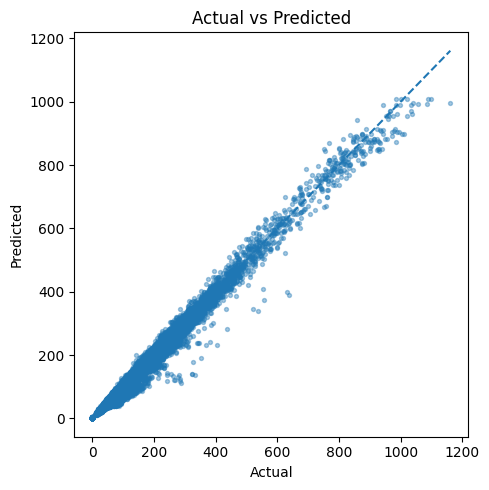

In [21]:
res = te[target] - te["y_pred"]

plt.figure(figsize=(6,4))
plt.hist(res, bins=40)
plt.title("Residuals Distribution (y - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(te[target], te["y_pred"], s=8, alpha=0.4)
plt.plot([0, te[[target,'y_pred']].max().max()],
         [0, te[[target,'y_pred']].max().max()],
         linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


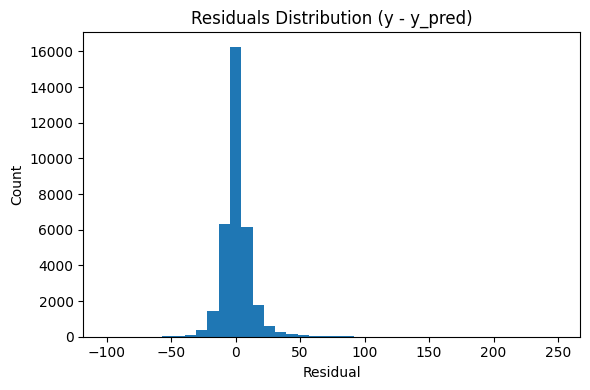

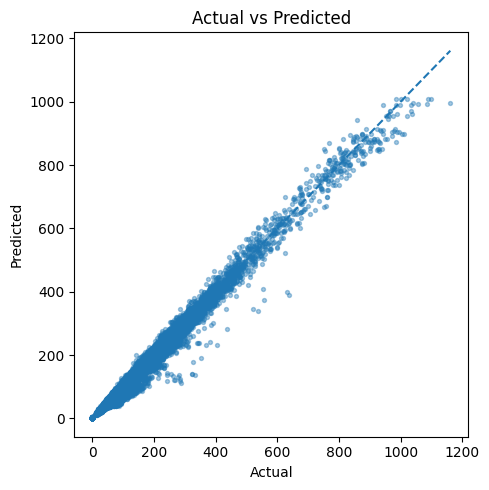

In [9]:
res = te[target] - te["y_pred"]

plt.figure(figsize=(6,4))
plt.hist(res, bins=40)
plt.title("Residuals Distribution (y - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(te[target], te["y_pred"], s=8, alpha=0.4)
plt.plot([0, te[[target,'y_pred']].max().max()],
         [0, te[[target,'y_pred']].max().max()],
         linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_49976\1095226514.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,year,month,n,mae,mape
0,2024,1,2600.0,6.438685,9.189237
1,2024,2,2600.0,13.821889,15.250491
2,2024,3,2600.0,6.876001,6.521788
3,2024,4,3250.0,7.509772,7.116468
4,2024,5,2600.0,6.758433,5.421142
5,2024,6,2600.0,6.966073,5.754650
6,2024,7,3250.0,7.040105,5.728708
7,2024,8,2600.0,7.301332,5.871385
8,2024,9,3250.0,6.148192,5.303166
9,2024,10,2600.0,6.047961,6.058700


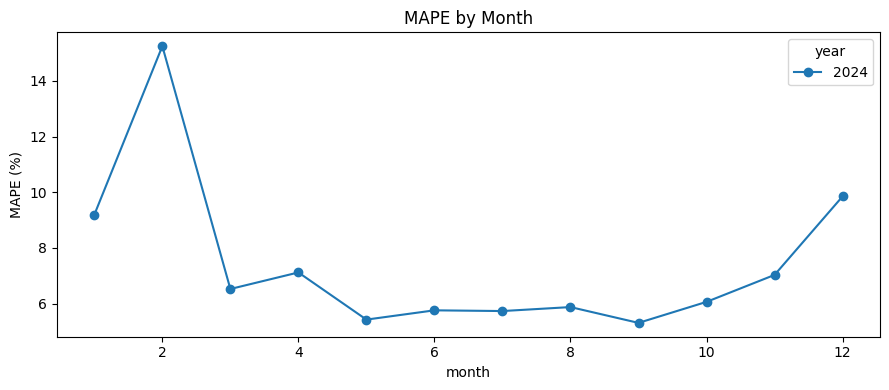

In [10]:
tmp = te.copy()
tmp["year"] = pd.to_datetime(tmp["target_date"]).dt.year
tmp["month"] = pd.to_datetime(tmp["target_date"]).dt.month
by_month = (tmp.groupby(["year","month"])
              .apply(lambda g: pd.Series({
                  "n": len(g),
                  "mae": np.abs(g[target]-g["y_pred"]).mean(),
                  "mape": mape(g[target].values, g["y_pred"].values)
              }))
              .reset_index())
display(by_month.sort_values(["year","month"]).head(24))

# 월별 MAPE 라인
pivot = by_month.pivot(index="month", columns="year", values="mape")
pivot.plot(figsize=(9,4), marker="o")
plt.title("MAPE by Month")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()


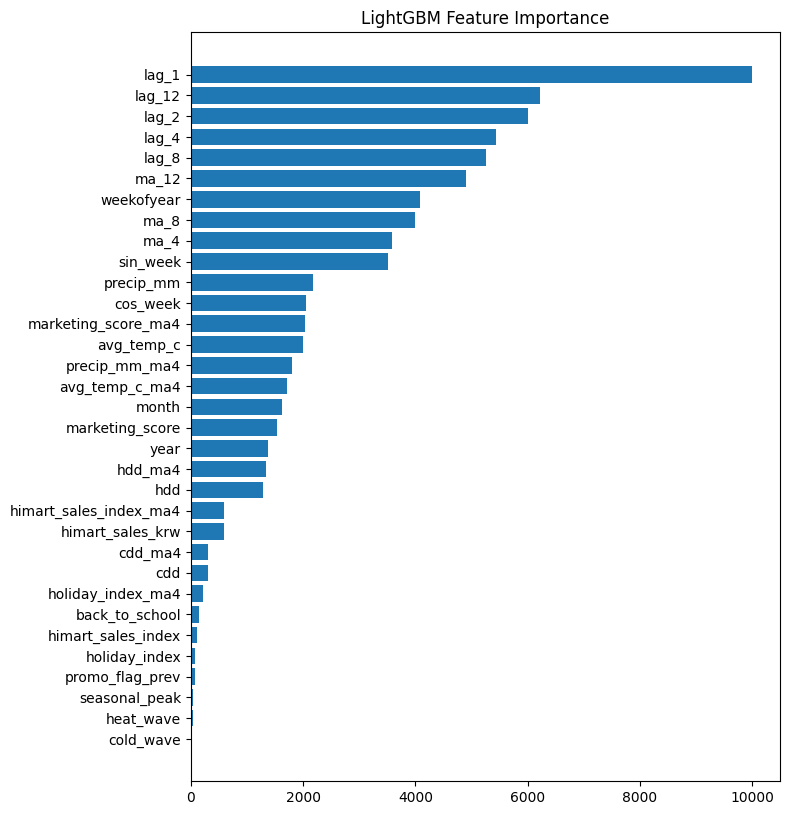

In [11]:
import numpy as np

if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({
        "feature": features,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, max(4, 0.25*len(fi))))
    plt.barh(fi["feature"][::-1], fi["importance"][::-1])
    plt.title("LightGBM Feature Importance")
    plt.tight_layout()
    plt.show()

    fi.head(20)
else:
    print("모델이 feature_importances_를 제공하지 않습니다.")


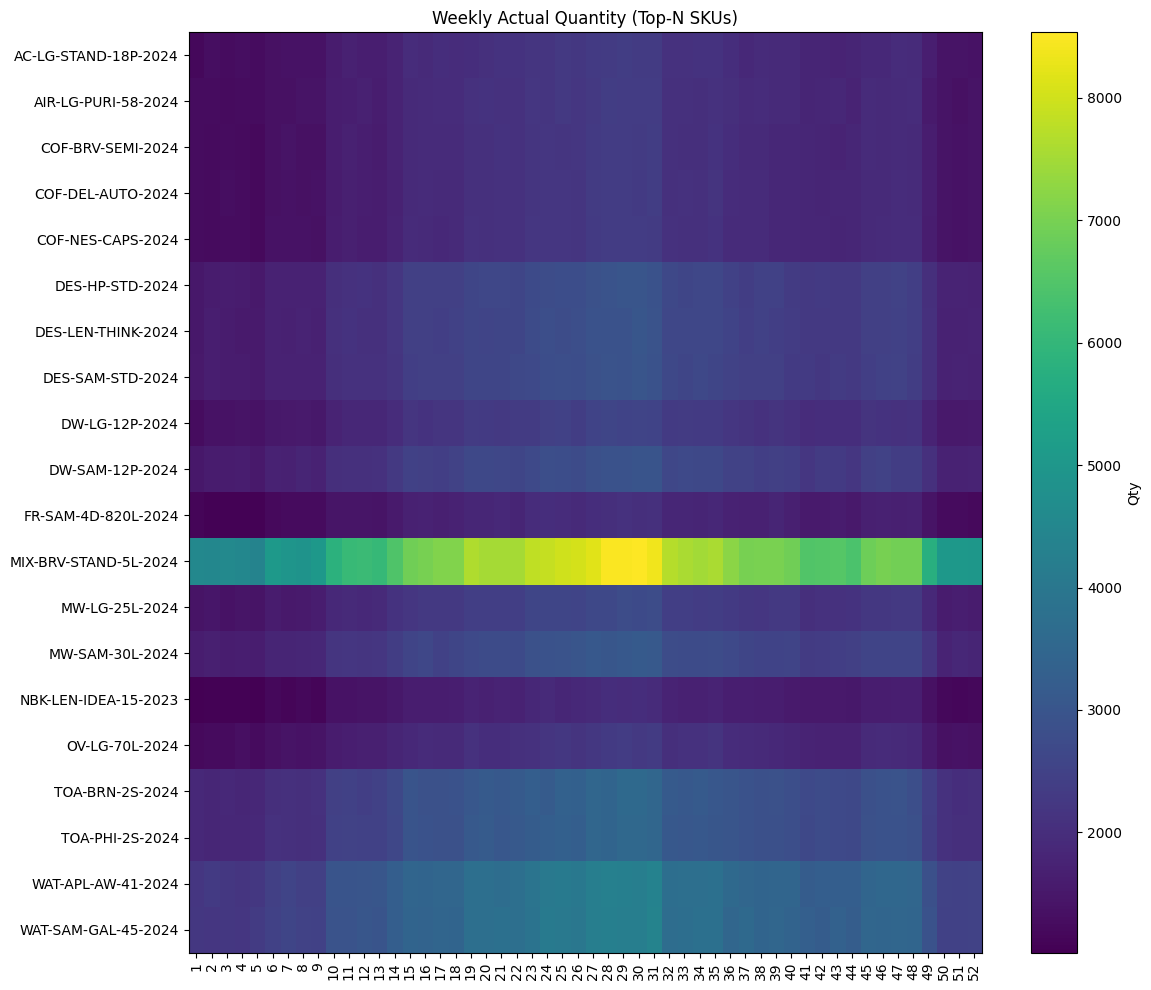

In [12]:
N = 20
topN = sku_eval.head(N).index.tolist()
g = te[te["sku_id"].isin(topN)].copy()
g["week"] = pd.to_datetime(g["target_date"]).dt.isocalendar().week.astype(int)

pv = g.pivot_table(index="sku_id", columns="week", values=(target), aggfunc="sum").fillna(0)
plt.figure(figsize=(12, 0.4*len(topN)+2))
plt.imshow(pv.values, aspect="auto")
plt.yticks(range(len(pv.index)), pv.index)
plt.xticks(range(len(pv.columns)), pv.columns, rotation=90)
plt.title("Weekly Actual Quantity (Top-N SKUs)")
plt.colorbar(label="Qty")
plt.tight_layout()
plt.show()


In [34]:
from pathlib import Path
import json, numpy as np, pandas as pd, joblib
import matplotlib.pyplot as plt

# 노트북을 repo 루트에서 열었다고 가정
BASE = Path.cwd() / "app" / "data_pipeline"
TR = BASE / "features_train.csv"
TE = BASE / "features_test.csv"
MODEL_PATH = BASE / "lightgbm_model.pkl"
FEATS_JSON = BASE / "lightgbm_features.json"

tr = pd.read_csv(TR, parse_dates=["target_date"])
te = pd.read_csv(TE, parse_dates=["target_date"])
model = joblib.load(MODEL_PATH)
with open(FEATS_JSON, "r", encoding="utf-8") as f:
    features = json.load(f)

def add_prev_flags(df):
    if "promo_flag" in df.columns:
        df["promo_flag_prev"] = (
            df.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"]
              .shift(1).fillna(0)
        )
    return df

tr = add_prev_flags(tr)
te = add_prev_flags(te)
for c in features:
    tr[c] = tr[c].fillna(0)
    te[c] = te[c].fillna(0)

print("features:", len(features))


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\chosw\\ORDER101_DEMAND_FORECAST\\be18-fin-SYNERGY-ORDER101\\python-server\\notebooks\\app\\data_pipeline\\features_train.csv'

In [35]:
from sklearn.metrics import mean_absolute_error

TARGET="y"
best_iter = getattr(model, "best_iteration_", None)

te_25 = te[te["target_date"].dt.year==2025].copy()
te_25["y_pred"] = np.clip(model.predict(te_25[features], num_iteration=best_iter), 0, None)

mae_25 = mean_absolute_error(te_25[TARGET], te_25["y_pred"])
print("2025 MAE:", mae_25, " (rows:", len(te_25), ")")
te_25.head()


ValueError: Input data must be 2 dimensional and non empty.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path(r"C:/Users/chosw/ORDER101_DEMAND_FORECAST/be18-fin-SYNERGY-ORDER101/python-server/app/data_pipeline")
tr = pd.read_csv(BASE/"features_train.csv", parse_dates=["target_date"])
te = pd.read_csv(BASE/"features_test.csv", parse_dates=["target_date"])

TARGET = "y"
ID_KEYS = ["warehouse_id","store_id","sku_id","region","target_date","split"]
LEAKY  = {"actual_order_qty", "share_norm", "promo_flag"}   # 현주 정보 금지

# 이전주 프로모션만 사용(있을 때)
for df_ in (tr, te):
    if "promo_flag" in df_.columns:
        df_["promo_flag_prev"] = (
            df_.groupby(["warehouse_id","store_id","sku_id"])["promo_flag"].shift(1).fillna(0)
        )

# 약한/거의 상수 변수 제거(있으면)
DROP_WEAK = [c for c in ["heat_wave","cold_wave"] if c in tr.columns]
tr = tr.drop(columns=DROP_WEAK, errors="ignore")
te = te.drop(columns=DROP_WEAK, errors="ignore")

# 피처 컬럼 만들기
numeric_cols = tr.select_dtypes(include=["number","bool"]).columns.tolist()
ignore = set(ID_KEYS + [TARGET]) | LEAKY
features = [c for c in numeric_cols if c not in ignore]
if "promo_flag_prev" in tr.columns and "promo_flag_prev" not in features:
    features.append("promo_flag_prev")

# NaN 채우기
for c in features:
    if tr[c].dtype.kind in "fi":
        tr[c] = tr[c].fillna(0.0); te[c] = te[c].fillna(0.0)
    else:
        tr[c] = tr[c].fillna(0);   te[c] = te[c].fillna(0)

len(features), features[:10]


(31,
 ['lag_1',
  'lag_2',
  'lag_4',
  'lag_8',
  'lag_12',
  'ma_4',
  'ma_8',
  'ma_12',
  'year',
  'weekofyear'])

In [2]:
def clip_outliers_groupwise(df, key_cols, y_col=TARGET, k=3.0):
    def _clip(g):
        q1, q3 = g[y_col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lo, hi = q1 - k*iqr, q3 + k*iqr
        g[y_col] = g[y_col].clip(lower=max(lo, 0), upper=hi)
        return g
    return df.groupby(key_cols, group_keys=False).apply(_clip)

tr = clip_outliers_groupwise(tr, ["warehouse_id","store_id","sku_id"])



C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_69932\217295582.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(key_cols, group_keys=False).apply(_clip)


NameError: name 'tr_sorted' is not defined

In [23]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error

def drop_low_variance(df_train, cols, nunique_thresh=1, var_thresh=1e-8):
    nun = df_train[cols].nunique()
    low_nun = nun[nun <= nunique_thresh].index.tolist()
    var = df_train[cols].var(numeric_only=True).fillna(0.0)
    low_var = var[var <= var_thresh].index.tolist()
    drop = sorted(set(low_nun + low_var))
    keep = [c for c in cols if c not in drop]
    return keep, drop

features, dropped_const = drop_low_variance(tr, features)
print("🔎 dropped constant/low-var features:", dropped_const)


def time_folds_last_k(g, n_folds=3, val_weeks=12, gap=1):
    """시계열 그룹 g(target_date 기준)에서 뒤쪽부터 n_folds개 폴드 생성."""
    g = g.sort_values("target_date")
    folds = []
    end_idx = len(g)
    for _ in range(n_folds):
        val_end   = end_idx
        val_start = max(0, val_end - val_weeks)
        tr_end    = max(0, val_start - gap)
        if tr_end <= 0 or val_start >= val_end: break
        folds.append((g.iloc[:tr_end], g.iloc[val_start:val_end]))
        end_idx = tr_end
    return folds

# 모든 시계열 합쳐서 폴드 샘플링(큰 데이터라 샘플 일부만 사용 권장)
keys = ["warehouse_id","store_id","sku_id"]
tr_sorted = tr.sort_values(keys+["target_date"]).copy()

folds = []
for _, g in tr_sorted.groupby(keys):
    # 판매량 많은 시계열만 폴드 구성(연산량 조절)
    if len(g) >= 60:
        folds += time_folds_last_k(g, n_folds=2, val_weeks=12, gap=2)
    if len(folds) > 150:   # 폴드 수 한도(연산시간 관리)
        break

def run_one_fold(tr_fit, tr_val, features):
    X_tr, y_tr = tr_fit[features], tr_fit[TARGET]
    X_va, y_va = tr_val[features], tr_val[TARGET]

    model = LGBMRegressor(
        objective="poisson",      # 카운트 안정화
        n_estimators=4000,
        learning_rate=0.01,
        num_leaves=31,
        max_depth=8,
        min_child_samples=64,     # 규제↑
        min_split_gain=0.0,
        subsample=0.7, subsample_freq=1,
        colsample_bytree=0.7,
        reg_alpha=1.0,            # L1↑
        reg_lambda=1.0,           # L2↑
        random_state=42
    )
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="mae",
        callbacks=[early_stopping(300, first_metric_only=True),
                   log_evaluation(200)]
    )
    pred = np.clip(model.predict(X_va, num_iteration=getattr(model, "best_iteration_", None)), 0, None)
    return mean_absolute_error(y_va, pred), model

cv_maes = []
for i, (tr_fit, tr_val) in enumerate(folds, 1):
    mae, _ = run_one_fold(tr_fit, tr_val, features)
    cv_maes.append(mae)
    if i % 20 == 0:
        print(f"[{i}/{len(folds)}] running...")

print(f"CV folds: {len(cv_maes)}, MAE(avg)={np.mean(cv_maes):.3f} ± {np.std(cv_maes):.3f}")


🔎 dropped constant/low-var features: []
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 396, number of used features: 24
[LightGBM] [Info] Start training from score 3.561605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

KeyboardInterrupt: 

In [ ]:
# 내부 검증 분리
tr_sorted["idx_in_grp"] = tr_sorted.groupby(keys).cumcount()
tr_sorted["grp_size"]   = tr_sorted.groupby(keys)[TARGET].transform("size")
tr_sorted["is_val"]     = (tr_sorted["grp_size"] - tr_sorted["idx_in_grp"]) <= 12
tr_fit = tr_sorted.loc[~tr_sorted["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])
tr_val = tr_sorted.loc[ tr_sorted["is_val"]].drop(columns=["idx_in_grp","grp_size","is_val"])

X_tr, y_tr = tr_fit[features], tr_fit[TARGET]
X_va, y_va = tr_val[features], tr_val[TARGET]

final = LGBMRegressor(
    objective="poisson",
    n_estimators=4000, learning_rate=0.01,
    num_leaves=31, max_depth=8,
    min_child_samples=64,
    subsample=0.7, subsample_freq=1,
    colsample_bytree=0.7,
    reg_alpha=1.0, reg_lambda=1.0,
    random_state=42
)
final.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    eval_metric="mae",
    callbacks=[early_stopping(300, first_metric_only=True), log_evaluation(200)]
)
best_iter = getattr(final, "best_iteration_", None); best_iter


In [ ]:
from sklearn.metrics import mean_absolute_error

te_pred = np.clip(final.predict(te[features], num_iteration=best_iter), 0, None)
te_eval = te.copy()
te_eval["y_pred"] = te_pred

mae  = mean_absolute_error(te_eval[TARGET], te_eval["y_pred"])
mape = (np.abs(te_eval[TARGET] - te_eval["y_pred"]) / np.maximum(te_eval[TARGET], 1)).mean()*100
print(f"TEST MAE={mae:.3f} | MAPE={mape:.2f}% | best_iter={best_iter}")

# 2025년만 보기
mask_2025 = te_eval["target_date"].dt.year == 2025
print("2025 rows:", mask_2025.sum())

# 상위 매출 SKU 1개 그려보기
top_sku = (te_eval.groupby("sku_id")["y"].sum().sort_values(ascending=False).index[0])
g = te_eval[(te_eval["sku_id"]==top_sku) & mask_2025].sort_values("target_date")

import matplotlib.pyplot as plt
plt.figure(figsize=(11,4))
plt.plot(g["target_date"], g["y"], label="Actual")
plt.plot(g["target_date"], g["y_pred"], label="Predicted")
plt.title(f"2025 • SKU={top_sku}")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Gain importance
imp_gain = pd.Series(final.booster_.feature_importance(importance_type="gain"),
                     index=features).sort_values(ascending=False)
plt.figure(figsize=(6,5))
imp_gain.head(20).sort_values().plot(kind="barh")
plt.title("LightGBM Feature Importance (gain) — top20")
plt.tight_layout(); plt.show()

# Permutation importance on a small sample for speed
from sklearn.inspection import permutation_importance
sample = te_eval.sample(10000, random_state=42) if len(te_eval) > 10000 else te_eval.copy()
perm = permutation_importance(final, sample[features], sample[TARGET], n_repeats=5, random_state=42, scoring="neg_mean_absolute_error")
pi = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)
pi.head(20)
